In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import folium
import json
import scipy

# metrics
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# models
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Directory of the raw data files
_data_root = r'../data'

# Name of each data directory
_tides_root = r'tides'
_waves_root = r"waves"

### Loading the Data

In [3]:
# Ingesting data
# Creating original dataframe to concat - tides
df_tides = pd.DataFrame()
for file in os.listdir(os.path.join(_data_root, _tides_root)):
    df_tides_to_concat = pd.read_csv(os.path.join(_data_root, _tides_root, file), skiprows=[1])
    df_tides = pd.concat([df_tides, df_tides_to_concat])

# Creating original dataframe to concat - waves
df_waves = pd.DataFrame()
for file in os.listdir(os.path.join(_data_root, _waves_root)):
    df_waves_to_concat = pd.read_csv(os.path.join(_data_root, _waves_root, file), skiprows=[1])
    df_waves = pd.concat([df_waves, df_waves_to_concat])

In [4]:
# checking if all files have been correctly loaded

number_of_files_tides = len(os.listdir(os.path.join(_data_root, _tides_root)))
number_of_unique_stations_tides = df_tides['station_id'].nunique()

number_of_files_waves = len(os.listdir(os.path.join(_data_root, _waves_root)))
number_of_unique_stations_waves = df_waves['station_id'].nunique()

if number_of_files_tides != number_of_unique_stations_tides or number_of_files_waves != number_of_unique_stations_waves:
    print('Number of files different than unique stations.')
else:
    print('All files have been loaded correctly.')

All files have been loaded correctly.


In [5]:
# Transforming time columns

df_waves['time'] = pd.to_datetime(df_waves['time'])
df_tides['time'] = pd.to_datetime(df_tides['time'])

# we are creating month number and name columns to be visually pleasant for charts
df_waves['month_number'] = df_waves['time'].dt.month
df_tides['month_number'] = df_tides['time'].dt.month

df_waves['month_name'] = df_waves['time'].apply(lambda x: x.strftime('%b'))
df_tides['month_name'] = df_tides['time'].apply(lambda x: x.strftime('%b'))

In [6]:
df_waves.head()

,longitude,latitude,time,station_id,PeakPeriod,PeakDirection,UpcrossPeriod,SignificantWaveHeight,Hmax,SeaTemperature,MeanCurSpeed,MeanCurDirTo,month_number,month_name
0,-9.262278,53.228333,2021-09-16 00:05:00+00:00,SmartBay Wave Buoy,NaN,NaN,NaN,NaN,NaN,16.72,NaN,NaN,9,Sep
1,-9.262278,53.228333,2021-09-16 00:10:00+00:00,SmartBay Wave Buoy,NaN,NaN,NaN,NaN,NaN,16.72,0.108,23.912088,9,Sep
2,-9.262278,53.228333,2021-09-16 00:15:00+00:00,SmartBay Wave Buoy,NaN,NaN,NaN,NaN,NaN,16.72,NaN,NaN,9,Sep
3,-9.262278,53.228333,2021-09-16 00:20:00+00:00,SmartBay Wave Buoy,NaN,NaN,NaN,NaN,NaN,16.72,0.138,29.010988,9,Sep
4,-9.262278,53.228333,2021-09-16 00:25:00+00:00,SmartBay Wave Buoy,NaN,NaN,NaN,NaN,NaN,16.72,NaN,NaN,9,Sep


In [7]:
df_tides.head()

,time,station_id,latitude,longitude,Water_Level_LAT,Water_Level_OD_Malin,QC_Flag,month_number,month_name
0,2021-10-13 21:40:00+00:00,Kinvara - Unreferenced,53.14052,-8.93758,NaN,-2.58,1,10,Oct
1,2021-10-13 21:45:00+00:00,Kinvara - Unreferenced,53.14052,-8.93758,NaN,-2.58,1,10,Oct
2,2021-10-13 21:50:00+00:00,Kinvara - Unreferenced,53.14052,-8.93758,NaN,-2.54,1,10,Oct
3,2021-10-13 21:55:00+00:00,Kinvara - Unreferenced,53.14052,-8.93758,NaN,-2.49,1,10,Oct
4,2021-10-13 22:00:00+00:00,Kinvara - Unreferenced,53.14052,-8.93758,NaN,-2.45,1,10,Oct


### Question 1. - What is the lowest temperature of each one of the Bouys?

In [8]:
columns_to_keep = ['station_id', 'SeaTemperature']

# grouping the dataframe for buoy, getting the min of each column and selecting only the columns we want
lowest_temperature_per_buoy = (df_waves.groupby('station_id')
                                       .min()
                                       .sort_values(by='SeaTemperature', ascending=True)
                                       .reset_index(drop=False)
                            )[columns_to_keep]

In [9]:
fig = px.bar(lowest_temperature_per_buoy, x='station_id', y='SeaTemperature', title='Lowest Temperature per Buoy', text_auto='.2s', template='simple_white', color='station_id', color_discrete_sequence=px.colors.qualitative.Plotly)
fig.update_traces(textfont_size=16, textangle=0, textposition="outside", cliponaxis=False, showlegend=False)

### Question 1.a - Which usually month it occurs?

In [10]:
# create a copy for a new dataframe
lowest_temperature_and_month_per_buoy = lowest_temperature_per_buoy.copy()

# let's iterate through every lowest buoy temperature
for index, row in lowest_temperature_and_month_per_buoy.iterrows():
    # copy to avoid modificating the original dataframe
    row = row.copy()
    # since we want to know the month that the lowest temperature generally occurs, we can filter in the original dataset the buoy and the value of the lowest temperature
    filtered_row_to_add = df_waves.loc[(df_waves['station_id'] == row['station_id']) & (df_waves['SeaTemperature'] == row['SeaTemperature'])]
    # now, we use the mode because we can have more than one month that these combination may occur. Since we want to know when it generally occurs, the mode fits
    row['month_name'] = filtered_row_to_add['month_name'].mode().squeeze()
    row['month_number'] = filtered_row_to_add['month_number'].mode().squeeze()
    # checking if the name it is a string and the month number it is a number
    if isinstance(row['month_name'], str) and isinstance(row['month_number'], int):
        # get the index of the row and add the value to the new column
        lowest_temperature_and_month_per_buoy.loc[index, 'month_name_of_occurrence'] = row['month_name']
        lowest_temperature_and_month_per_buoy.loc[index, 'month_number_of_occurrence'] = row['month_number']
    else:
        print('Wrong format')

In [11]:
lowest_temperature_and_month_per_buoy

,station_id,SeaTemperature,month_name_of_occurrence,month_number_of_occurrence
0,Brandon Bay,4.47,Mar,3.0
1,Bantry Bay,5.27,Mar,3.0
2,SmartBay Wave Buoy,5.31,Jan,1.0
3,Clew Bay,7.50,Mar,3.0
4,AMETS Berth B Wave Buoy,8.15,Mar,3.0
5,AMETS Berth A Wave Buoy,8.55,Mar,3.0


In [12]:
fig = px.bar(lowest_temperature_and_month_per_buoy, x='station_id', y='month_number_of_occurrence', title='Month of Lowest Temperature per Buoy', text_auto='.2s', template='simple_white', color='month_name_of_occurrence')
fig.update_traces(textfont_size=16, textangle=0, textposition="outside", cliponaxis=False)

### Question 2. - Where (lat/long) do we have the biggest water level?

In [13]:
df_tides.head()

,time,station_id,latitude,longitude,Water_Level_LAT,Water_Level_OD_Malin,QC_Flag,month_number,month_name
0,2021-10-13 21:40:00+00:00,Kinvara - Unreferenced,53.14052,-8.93758,NaN,-2.58,1,10,Oct
1,2021-10-13 21:45:00+00:00,Kinvara - Unreferenced,53.14052,-8.93758,NaN,-2.58,1,10,Oct
2,2021-10-13 21:50:00+00:00,Kinvara - Unreferenced,53.14052,-8.93758,NaN,-2.54,1,10,Oct
3,2021-10-13 21:55:00+00:00,Kinvara - Unreferenced,53.14052,-8.93758,NaN,-2.49,1,10,Oct
4,2021-10-13 22:00:00+00:00,Kinvara - Unreferenced,53.14052,-8.93758,NaN,-2.45,1,10,Oct


In [14]:
df_tides.tail()

,time,station_id,latitude,longitude,Water_Level_LAT,Water_Level_OD_Malin,QC_Flag,month_number,month_name
82871,2022-09-16 20:05:00+00:00,Skerries Harbour,53.585,-6.1081,1.318,-1.541,0,9,Sep
82872,2022-09-16 20:10:00+00:00,Skerries Harbour,53.585,-6.1081,1.247,-1.612,0,9,Sep
82873,2022-09-16 20:15:00+00:00,Skerries Harbour,53.585,-6.1081,1.274,-1.585,0,9,Sep
82874,2022-09-16 20:20:00+00:00,Skerries Harbour,53.585,-6.1081,1.183,-1.676,0,9,Sep
82875,2022-09-16 20:25:00+00:00,Skerries Harbour,53.585,-6.1081,1.181,-1.678,0,9,Sep


In [15]:
# Since there are two water level columns, I did a little research to know wich one to use.
# Lowest astronomical tide (LAT) is defined as the lowest tide level which can be predicted to occur under average meteorological conditions and under any combination of astronomical conditions.
# an ordnance datum or OD is a vertical datum used by an ordnance survey as the basis for deriving altitudes on maps. OD usually it is relative to the MSL (Mean Sea Level)

# I decided to use LAT because it it more widely used.
highest_water_level = df_tides.loc[df_tides['Water_Level_LAT'] == df_tides['Water_Level_LAT'].max()]

In [16]:
highest_water_level

,time,station_id,latitude,longitude,Water_Level_LAT,Water_Level_OD_Malin,QC_Flag,month_number,month_name
23685,2021-12-07 07:30:00+00:00,Galway Port,53.269,-9.048,6.143,3.176,1,12,Dec


In [17]:
# instantiate the map
map = folium.Map(location=[highest_water_level['latitude'], highest_water_level['longitude']], zoom_start=7)

# define the style of the text on the popup
popup_string = '<body style="font-size: 10px; font-family: Verdana;">'
# add each value of the series to the popup string
for key, value in highest_water_level.iloc[0].to_dict().items():
    popup_string = popup_string + f'<p>{key}={value}</p>'

# create a tooltip when hovering the cursor
tooltip="Highest Water Level"

# create the market on the highest water level
folium.Marker(
    [highest_water_level['latitude'], highest_water_level['longitude']], 
    popup=popup_string,
    tooltip=tooltip
).add_to(map)

# display the map
map

### Question 2.a - Which usually month it occurs?

In [18]:
df_tides_per_month_max = df_tides.groupby([pd.Grouper(key='time', freq='MS')]).max().reset_index()

In [19]:
fig = px.line(df_tides_per_month_max, x='time', y='Water_Level_LAT', title='Max Water Level_LAT (Monthly)', template='simple_white', text="Water_Level_LAT")
fig.update_traces(textposition="top center")
fig.add_annotation(
    # replace day, hour and minute because we grouped the months per MS (month start frequency)
    x=highest_water_level['time'].squeeze().replace(day=1, hour=0, minute=0),
    # add 0.01 to avoid overwrite
    y=highest_water_level['Water_Level_LAT'].squeeze() + 0.1,
    text=f"<b>The highest Water Level occurred in {highest_water_level['month_name'].squeeze()}</b>",
    font=dict(
        size=14
        ),
    arrowhead=2
)
fig

### Question 3. - How the Wave Lenghts correlates with Sea Temperature?

In [20]:
df_waves.head(1)

,longitude,latitude,time,station_id,PeakPeriod,PeakDirection,UpcrossPeriod,SignificantWaveHeight,Hmax,SeaTemperature,MeanCurSpeed,MeanCurDirTo,month_number,month_name
0,-9.262278,53.228333,2021-09-16 00:05:00+00:00,SmartBay Wave Buoy,NaN,NaN,NaN,NaN,NaN,16.72,NaN,NaN,9,Sep


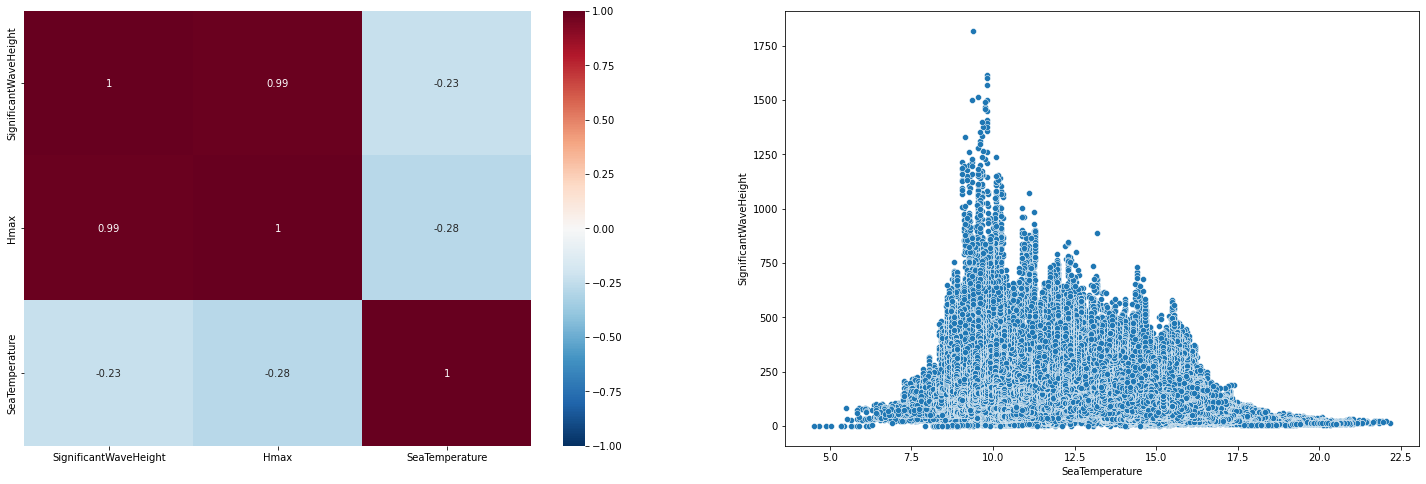

In [21]:
columns_to_correlate = ['SignificantWaveHeight', 'Hmax', 'SeaTemperature']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 8))
# utilizing Pearson Correlation
fig_1 = sns.heatmap(df_waves[columns_to_correlate].corr(), annot=True, cmap='RdBu_r', linecolor='black', vmin=-1, vmax=1, ax=ax1)
fig_2 = sns.scatterplot(x="SeaTemperature", y="SignificantWaveHeight", data=df_waves, ax=ax2)

plt.show()

The wave height have a weak and negative correlation with Sea Temperature

### Question 3.a - It is possible to predict with accuracy the Wave Lenght, based on the Sea Temperature and the Bouy location?

In [22]:
# Let's see some statistics of the data
df_waves.groupby('station_id')[['station_id', 'SignificantWaveHeight', 'SeaTemperature']].describe().reset_index()

station_id SignificantWaveHeight                          \
                                           count        mean         std   
0  AMETS Berth A Wave Buoy               16812.0  316.699798  185.696164   
1  AMETS Berth B Wave Buoy               16569.0  283.064518  160.940415   
2               Bantry Bay               15706.0   60.362537   41.346492   
3              Brandon Bay                7212.0  173.526900   91.102908   
4                 Clew Bay                9666.0  119.018105   70.116461   
5       SmartBay Wave Buoy               11717.0   82.665358   49.994963   

                                     SeaTemperature                       \
    min    25%    50%    75%     max          count       mean       std   
0   2.0  181.0  274.0  403.0  1617.0        16812.0  12.413886  2.292191   
1   2.0  166.0  247.0  362.0  1819.0        16569.0  11.960142  2.232190   
2   4.0   30.0   51.0   81.0   486.0        94264.0  12.584481  3.292467   
3   0.0  111.0  160.0  216.0   628.0        43319.0  11.704346  2.201066   
4  15.0   64.0  105.0  160.0   483.0         9666.0  11.202338  2.608078   
5   6.0   43.0   74.0  108.0   300.0        70362.0  12.479693  3.799434   

                                       
    min    25%    50%      75%    max  
0  8.55  10.10  12.30  14.3500  17.45  
1  8.15   9.65  12.05  14.0000  16.55  
2  5.27   9.57  12.02  15.0300  22.23  
3  4.47   9.74  10.90  13.4400  16.50  
4  7.50   9.00  10.00  13.0875  18.40  
5  5.31   8.70  12.44  16.5000  22.36

We can see that the mean and std of the Wave Heights seem to differ between buoys, although Sea Temperature don't.

Let's investigate with some statistics tests if the buoy location it is statically  significant.

In [23]:
# First, there's a lot of data. When we work with lots of time series data, the results may be much granulated due to the variations
# To overcome this, we will group the values to get the mean per day
df_waves_per_station_day_mean = df_waves.groupby(['station_id', pd.Grouper(key='time', freq='d')]).mean().reset_index()

### Anova

An ANOVA test is a type of statistical test used to determine if there is a statistically significant difference between two or more categorical groups by testing for differences of means using variance.

#### One Way Nova

The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean. The test is applied to samples from two or more groups, possibly with differing sizes.

Our groups are the Buoys Location, and our target it is the Wave Heights.

The ANOVA test has important assumptions that must be satisfied in order for the associated p-value to be valid.

- The samples are independent.
- Each sample is from a normally distributed population.
- The population standard deviations of the groups are all equal. This property is known as homoscedasticity.

In [24]:
target_column = 'SignificantWaveHeight'

#### Checking data normality

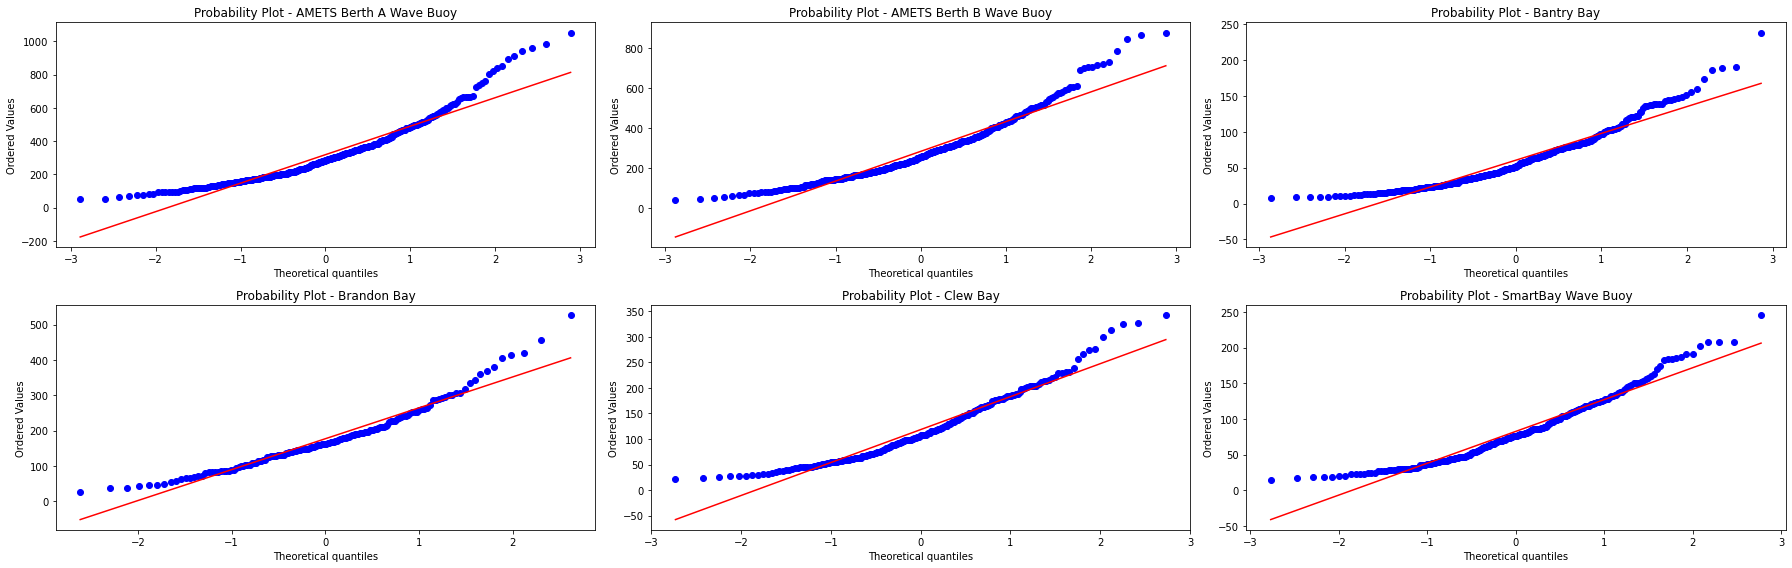

In [25]:
# To check if the samples are normally distributed, let's plot QQ-Plots.
fig = plt.figure(figsize=(25, 8))

unique_buoys = df_waves_per_station_day_mean['station_id'].unique()
for number, buoy in enumerate(unique_buoys, 1):
    plt.subplot(2, 3, number)
    scipy.stats.probplot(df_waves_per_station_day_mean[df_waves_per_station_day_mean['station_id'] == buoy][target_column], dist="norm", plot=plt)
    plt.title("Probability Plot - " +  buoy)

plt.tight_layout()
plt.show()

There are evidences that the data is not normally distributed, the QQ-Plots shows us that the data are skewed.

### Check if standard deviations of the groups are all equal

The Levene test tests the null hypothesis that all input samples are from populations with equal variances. Levene’s test is an alternative to Bartlett’s test bartlett in the case where there are significant deviations from normality.

$H_0: µ_1 = µ_2$ ("there is no difference in the variance of wave height between buoys")

$H_1: µ_1 ≠ µ_2$ ("there is a difference in the variance of wave height between buoys")

In [26]:
scipy.stats.levene(
    df_waves_per_station_day_mean.loc[(df_waves_per_station_day_mean['station_id'] == 'AMETS Berth A Wave Buoy')][target_column], 
    df_waves_per_station_day_mean.loc[(df_waves_per_station_day_mean['station_id'] == 'AMETS Berth B Wave Buoy')][target_column], 
    df_waves_per_station_day_mean.loc[(df_waves_per_station_day_mean['station_id'] == 'Bantry Bay')][target_column], 
    df_waves_per_station_day_mean.loc[(df_waves_per_station_day_mean['station_id'] == 'Brandon Bay')][target_column], 
    df_waves_per_station_day_mean.loc[(df_waves_per_station_day_mean['station_id'] == 'Clew Bay')][target_column], 
    df_waves_per_station_day_mean.loc[(df_waves_per_station_day_mean['station_id'] == 'SmartBay Wave Buoy')][target_column],
center='mean')

LeveneResult(statistic=114.14031010181242, pvalue=7.873188829913835e-104)

Since the P-Value it is lower than 0.05, there is a difference in the variance of wave height between buoys.

We didn't fill 2 of the 3 assumptions to ANOVA, that means that our results may not be fully trusted, but let's test the result of the test.

Anova Hyptohesis

-   $H_0: µ_1 = µ_2 = µ_3 = µ_4 = µ_5 = µ_6$ (the six population means are equal)
-   $H_1:$ At least one of the means differ

In [27]:
scipy.stats.f_oneway(
    df_waves_per_station_day_mean.loc[(df_waves_per_station_day_mean['station_id'] == 'AMETS Berth A Wave Buoy')][target_column], 
    df_waves_per_station_day_mean.loc[(df_waves_per_station_day_mean['station_id'] == 'AMETS Berth B Wave Buoy')][target_column], 
    df_waves_per_station_day_mean.loc[(df_waves_per_station_day_mean['station_id'] == 'Bantry Bay')][target_column], 
    df_waves_per_station_day_mean.loc[(df_waves_per_station_day_mean['station_id'] == 'Brandon Bay')][target_column], 
    df_waves_per_station_day_mean.loc[(df_waves_per_station_day_mean['station_id'] == 'Clew Bay')][target_column], 
    df_waves_per_station_day_mean.loc[(df_waves_per_station_day_mean['station_id'] == 'SmartBay Wave Buoy')][target_column],
)

F_onewayResult(statistic=267.3609349154022, pvalue=8.928212798194785e-210)

Since the P-Value it is lower than 0.05, we reject the null hypothesis as there is significant evidence that at least one of the means differ.

### Kruskal-Wallis H-test

If one of ANOVA assumptions are not true for a given set of data, it may still be possible to use the Kruskal-Wallis H-test (scipy.stats.kruskal) although with some loss of power.

The Kruskal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal. It is a non-parametric version of ANOVA. The test works on 2 or more independent samples, which may have different sizes. Note that rejecting the null hypothesis does not indicate which of the groups differs. Post hoc comparisons between groups are required to determine which groups are different.

In [28]:
scipy.stats.kruskal(
    df_waves_per_station_day_mean.loc[(df_waves_per_station_day_mean['station_id'] == 'AMETS Berth A Wave Buoy')][target_column], 
    df_waves_per_station_day_mean.loc[(df_waves_per_station_day_mean['station_id'] == 'AMETS Berth B Wave Buoy')][target_column], 
    df_waves_per_station_day_mean.loc[(df_waves_per_station_day_mean['station_id'] == 'Bantry Bay')][target_column], 
    df_waves_per_station_day_mean.loc[(df_waves_per_station_day_mean['station_id'] == 'Brandon Bay')][target_column], 
    df_waves_per_station_day_mean.loc[(df_waves_per_station_day_mean['station_id'] == 'Clew Bay')][target_column], 
    df_waves_per_station_day_mean.loc[(df_waves_per_station_day_mean['station_id'] == 'SmartBay Wave Buoy')][target_column],
    nan_policy='omit'
)

KruskalResult(statistic=993.0160226868268, pvalue=1.953777160551531e-212)

Since the P-Value it is lower than 0.05, we reject the null hypothesis as there is significant evidence that at least one of the means differ.

### Supervised Model

Since one of the means differs from others, it worths a shot creating a basic model to see how it performs.

In [29]:
# filter only valid target values
df_waves_for_modeling = df_waves.loc[df_waves['SignificantWaveHeight'].notnull()]

# define x and y
x = df_waves_for_modeling[['station_id', 'SeaTemperature']]
y = df_waves_for_modeling[target_column]

# split for train and test
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=0)

# create pipelines for every type of variable to pass to our ColumnTransformer 
# Categorical
catTransformer = Pipeline(steps=[
    # For categorical variables, we will use onehotencoder.
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Numerical
numTransformer = Pipeline(steps=[
    # For numerical features we will use standardscaler.
    ('scaler', StandardScaler())
])          
# Let's integrate those pipelines with a ColumnTransformer and create our preprocessor. Everytime that we wan't to predict, this preprocessor will be applied.
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, selector(dtype_exclude=["category", "object"])),
        ('categoric', catTransformer, selector(dtype_include=["category", "object"]))
])

Our target variable it's Wave Height (cm), that means that we need a supervised machine learning model and our target it is a continous variable, a regression problem.

I've chose to use RMSE as our metric because it is more sensible to outliers than MAE, so it gives us a wider comprehension if that is affecting our model.

For validation, we will use K-Fold Cross Validation. That means that the data will be divided by K groups of samples, called folds. Then, in every iteration of K, the data will be trained in K-1 and tested in the rest.

In [30]:
# We will use 5 folds
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True).get_n_splits(x_train.values)
    # here we define that our scoring metric will be rmse for every iteration of the cross validation
    rmse = np.sqrt(-cross_val_score(model, x_train, y_train,
                   scoring="neg_mean_squared_error", cv=kf))
    return rmse

In [31]:
model_pipeline = Pipeline(steps=[
                        ('preprocessor', preprocessor),
                        # our model it is a random forest, that uses bagging technique and usually performs well
                        ('model', RandomForestRegressor())
                    ])

In [32]:
rmse_list = rmsle_cv(model_pipeline)

In [33]:
print("Random Forest score: {:.3f} ({:.3f})\n".format(rmse_list.mean(), rmse_list.std()))

Random Forest score: 107.607 (1.619)



In [34]:
model_pipeline.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001AC8258ACD0>),
                                                 ('categoric',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001AC825C6490>)])),
                ('model', RandomForestRegressor())])

In [35]:
predicted_values = model_pipeline.predict(x_test)

### Evaluation

In [36]:
cv_rmse = rmse_list.mean()
cv_std = rmse_list.std()
rmse_testset = mean_squared_error(y_test, predicted_values, squared=False)
mae_testset = mean_absolute_error(y_test, predicted_values)
r2_score_testset = r2_score(y_test, predicted_values)

In [37]:
df_randomforest_eval = pd.DataFrame(
    [{
        "cv_rmse": cv_rmse,
        "cv_std": cv_std,
        "rmse": rmse_testset,
        "mae": mae_testset,
        "r2": r2_score_testset
    }]
)

In [38]:
df_randomforest_eval

,cv_rmse,cv_std,rmse,mae,r2
0,107.606755,1.619394,107.036608,70.126741,0.561911


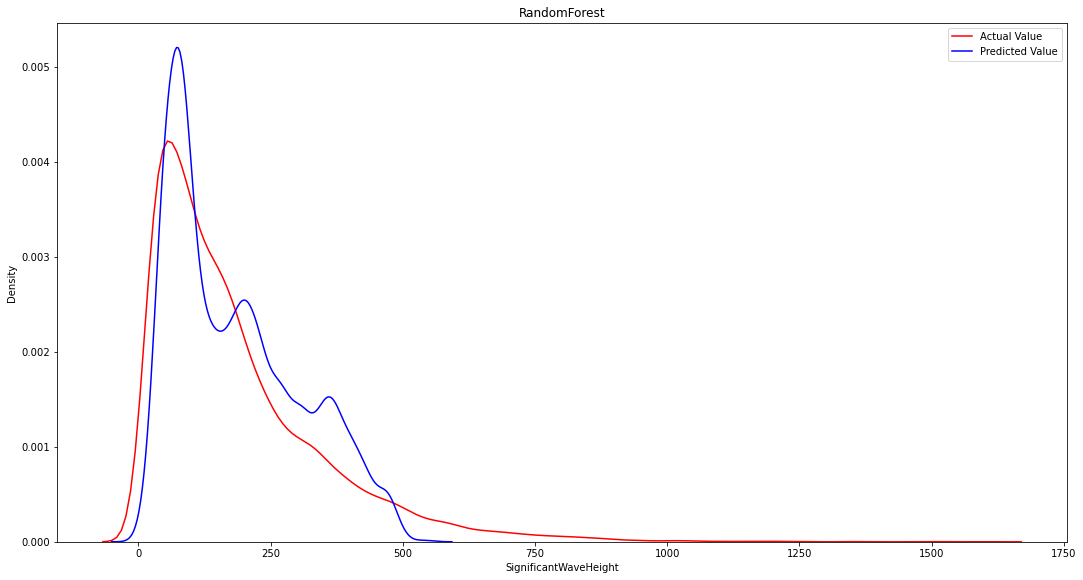

In [39]:
# Let's see the distribution of our predicted values in comparison with the actual values.
plt.figure(figsize=(15,8))
ax1 = sns.kdeplot(y_test,color ="r",label ="Actual Value")
sns.kdeplot(predicted_values ,color ="b",label = "Predicted Value",ax =ax1).set_title('RandomForest')
plt.legend()
plt.tight_layout(pad = 0.5)

### Conclusion

Our tests shows that there is significant evidence that at least one the means for Wave Height values differ between Buoys.

This was an indicator that the Buoy location may influence the Wave Height, but we can't be sure. Since the Sea Temperature is not a strong feature for predicting the Wave Height, I thought it worth creating a basic model to see how it performs.

With RandomForest we obtained a RMSE of 107.59 with cross-validation, and our r2 score it is 0.56 which indicates that our features may not explain the target very well. 

The model didn't perform very well, indicating that these 2 features are not enough to predict the Wave Height accurately, but with some adjustments it may improve.